## Imports and functions

In [2]:
import datetime
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings("ignore")

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [3]:
def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              sw_fw_matching_path_with_cnt: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict[str, pd.DataFrame]:
    
    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)
    
    temperature = pd.read_csv(temperature_path)
#     temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
#     temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
#     temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_matching_with_cnt = pd.read_csv(sw_fw_matching_path_with_cnt)

    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = pd.read_csv(mortality_path)
    mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    mortality['transport_year']= mortality['transfer_date'].dt.year


    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'sw_fw_matching_with_cnt': sw_fw_matching_with_cnt,
        'mortality': mortality
    }
    
    return dataframes

def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum
    
#this is to not calculate aggregates if at least one value on the main factor column is NaN
def apply_condition(group,main_factor,agg_function):
    if group[main_factor].isnull().any():
        return np.nan
    else:
        return agg_function(group[main_factor])


def create_ph_aggregated_factors(ph_df, main_factor, agg_function, function_name, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    
    after_ff_len = 4 * 7
    
    after_ff_period = ph_df['event_date'].between(
        ph_df['first_feeding_date'],
        ph_df['first_feeding_date'] + pd.to_timedelta(after_ff_len, unit='D')
    )

    before_transfer = ph_df['event_date'] < ph_df['shipout_date']

    after_vaccination = ph_df['event_date'] > ph_df['VAC_EVENT_DATE']
    before_vaccination = ph_df['event_date'] < ph_df['VAC_EVENT_DATE']

    after_first_feeding = ph_df['event_date'] > ph_df['first_feeding_date']

    week_before_vac = ph_df['event_date'] > ph_df['VAC_EVENT_DATE'] - pd.to_timedelta(1, unit='W')
    week_after_vac = ph_df['event_date'] < ph_df['VAC_EVENT_DATE'] + pd.to_timedelta(1, unit='W')

    agg_df = pd.DataFrame()
    
    agg_df[f'{env_type}-whole_period-{function_name}'] = ph_df\
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))
    
    agg_df[f'{env_type}-after_first_feeding-{function_name}'] = ph_df[after_ff_period] \
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))
    
    agg_df[f'{env_type}-transfer_feeding-{function_name}'] = ph_df[before_transfer & after_first_feeding] \
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))

    agg_df[f'{env_type}-transfer_vaccination-{function_name}'] = ph_df[before_transfer & after_vaccination]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    agg_df[f'{env_type}-vaccination-feeding-{function_name}'] = ph_df[before_vaccination & after_first_feeding]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    agg_df[f'{env_type}-around_vaccination-{function_name}'] = ph_df[week_after_vac & week_before_vac]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    
    mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})

    for col in agg_df.columns[:]:
        agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
        agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df


def create_degree_days_aggregated_factor(ph_df, main_factor, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    days = ph_df[before_transfer & after_first_feeding].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_transfer & after_first_feeding].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df['fw_cycle_length'] = days['diff']
    agg_df[f'{env_type}-transfer_feeding-degree_days'] = days['diff'] * degrees['mean']

    days = ph_df[before_transfer & after_vaccination].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_transfer & after_vaccination].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df[f'{env_type}-transfer_vaccination-degree_days'] = days['diff'] * degrees['mean']

    days = ph_df[before_vaccination & after_first_feeding].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_vaccination & after_first_feeding].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df[f'{env_type}-vaccination_feeding-degree_days'] = days['diff'] * degrees['mean']

    for week in weeks_before_transfer:
        weeks_before_transfer_date = ph_df['shipout_date'] - pd.to_timedelta(week, unit='W')
        condition = ph_df['event_date'] > weeks_before_transfer_date

        days = ph_df[before_transfer & condition].groupby('final_locus_population_id')['event_date'] \
        .agg(['max','min'])
        days['diff'] = (days['max'] - days['min']).dt.days
        degrees = ph_df[before_transfer & condition].groupby('final_locus_population_id')[main_factor] \
        .agg(['mean'])
        agg_df[f'{env_type}-{week}_weeks_before_transfer-degree_days'] = days['diff'] * degrees['mean']

#     mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})
    
#     for col in agg_df.columns[:]:
#         agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
#         agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df


def create_ph_aggregated_factors_threshold(ph_df, main_factor, lower_bound, upper_bound, agg_function, condition_type, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    higher_max = f'{env_type}-{condition_type}-higher_max-{upper_bound}'
    lower_min = f'{env_type}-{condition_type}-lower_min-{lower_bound}'
    btw_min_max = f'{env_type}-{condition_type}-btw_min_max-{lower_bound}-{upper_bound}'
    
    relative_higher_max = f'{env_type}-{condition_type}-relative_higher_max-{upper_bound}'
    relative_lower_min = f'{env_type}-{condition_type}-relative_lower_min-{lower_bound}'
    relative_out_min_max = f'{env_type}-{condition_type}-relative_out_min_max-{lower_bound}-{upper_bound}'


    agg_df[higher_max] = ph_df[ph_df[main_factor] > upper_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[lower_min] = ph_df[ph_df[main_factor] < lower_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[btw_min_max] = ph_df[ph_df[main_factor].between(lower_bound, upper_bound)]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df['measurements_count'] = ph_df.groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[higher_max] = agg_df[higher_max].fillna(0).astype('int64')
    agg_df[lower_min] = agg_df[lower_min].fillna(0).astype('int64')
    agg_df[btw_min_max] = agg_df[btw_min_max].fillna(0).astype('int64')

    
    agg_df[relative_higher_max] = agg_df[higher_max] / agg_df['measurements_count']
    agg_df[relative_lower_min] =  agg_df[lower_min] /  agg_df['measurements_count']
    agg_df[relative_out_min_max] = 1 - (agg_df[btw_min_max] /agg_df['measurements_count'])
    agg_df.drop(columns='measurements_count', inplace=True)
        
    return agg_df

def create_factors_df(agg_ph_df, factors, key_columns, weight_column, weighted_func):
    """Creates factors df on key_columns level using weight_column to calculate weighted average"""
    factors_dfs = []
    print('Weighting factors')
    for factor in tqdm(factors):
        tmp = agg_ph_df.groupby(key_columns)\
        .apply(weighted_func, weight_column, factor).reset_index().rename(columns={0: factor})
        factors_dfs.append(tmp)

    factor_df = factors_dfs[0]
    for df in factors_dfs[1:]:
        factor_df = factor_df.merge(df, on=key_columns, how='inner')
    return factor_df

def plot_factors(factors_df, path):
    pairplot = sns.pairplot(factors_df[np.append(corr_df.index, 'mortality')], size=(20, 15))
    plt.title('Mortality vs feature pairplot')
    plt.show()

    for ax in pairplot.axes.flatten():
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation=0)
        # set y labels alignment
        ax.xaxis.get_label().set_horizontalalignment('right')
        ax.yaxis.get_label().set_horizontalalignment('right')
    pairplot.figure.savefig(path / 'mortality_vs_feature_pairplot.jpg')

def plot_swarm(df, factor, target, bins, y_scale=1, title=''):
    sns.set_style("whitegrid")

    arr_for_chart = df.copy()
    arr_for_chart[factor+'_binned'] = pd.cut(df[factor], bins=bins)
    arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100
    arr_for_chart['TGC_SW'] = arr_for_chart['TGC_SW']
    x_axis_factor = factor + '_binned'

    plt.figure()
    f, axs = plt.subplots(1, 1, figsize=(18,8), sharex=True)
    box_plot = sns.swarmplot(data=arr_for_chart, x=x_axis_factor, y=target)

    mean_target = arr_for_chart.groupby(x_axis_factor)[target].mean()
    mean_main_factor = arr_for_chart.groupby(x_axis_factor)[main_factor].mean() 

#     vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,
                      mean_target.iloc[xtick],
                      round(mean_target.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='black',
                      weight='semibold')
        box_plot.text(xtick,
                      mean_main_factor.iloc[xtick] / y_scale,
                      round(mean_main_factor.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='darkblue',
                      weight='semibold')
    
    plt.title(f'Swarmplot {title}: {target} vs. {factor}')
    axs.legend(
        arr_for_chart[x_axis_factor].value_counts().sort_index().apply(lambda x: 'Sample count: ' + str(x)),
        loc='upper right'
    )

    f.show()

#     f.savefig(f'swarmplot_{target}_vs_{factor}.jpg')

## Data processing

In [ ]:
dataframes = load_data(locus_weights_path='../data/evt_movement_ratio_with_dates.csv',
                       temperature_path='../data/FW_temperature_cleared.csv',
                       locus_group_matching_path='../data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='../data/FW_cycle_dates.csv',
                       sw_fw_matching_path='../data/seawater_freshwater_matching.csv',
                       sw_fw_matching_path_with_cnt='../data/sw_locus_fw_locus_population_with_counts.csv',
                       final_locus_weighted_path='../data/lw_alldates_final.csv', #_locus
                       mortality_path='../data/smolt_dataset_transfers.csv') #_until2023Feb28_narrow

temperature = dataframes['temperature']
locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']
sw_fw_matching_with_cnt = dataframes['sw_fw_matching_with_cnt']

#tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')
vaccines = pd.read_csv('../data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
vaccines_agg = pd.DataFrame(vaccines.groupby('FINAL_LOCUS_POPULATION_ID')['VAC_EVENT_DATE'].max())
fresh_water_dates.rename(columns={'pretransfer_fw_locus_population_id': 'final_locus_population_id'}, inplace=True)
sw_fw_matching.transport_date = pd.to_datetime(sw_fw_matching.transport_date, format=TIME_FORMAT)
sw_fw_matching_with_cnt.transfer_date = pd.to_datetime(sw_fw_matching_with_cnt['transfer_date'], format=TIME_FORMAT)
sw_fw_matching_with_cnt['transfer_year'] = sw_fw_matching_with_cnt['transfer_date'].dt.year

temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
temperature['event_year'] = temperature['event_date'].dt.year

In [ ]:
treatment = pd.read_csv('../data/treatment_ts_full_range_flp_grouped_DE.csv')

In [ ]:
treatment.columns

In [ ]:
treatment = treatment.merge(
    fresh_water_dates,
    how='inner',
)

treatment = treatment.merge(
    vaccines_agg,
    left_on='final_locus_population_id',
    right_on='FINAL_LOCUS_POPULATION_ID',
    how='inner'
)

treatment['shipout_year'] = treatment['shipout_date'].dt.year

In [ ]:
mortality_cols = ['locus_id',
                  'fish_group_id',
                  'transfer_year',
                  'transfer_month',
                  'transfer_month_year',
                  'transfer_season',
                  'transfer_season2',
                  'total_count',
                  'total_mortality_perc_90']

sw_cols = ['to_locus_id',
           'to_fish_group_id',
           'transfer_date',
           'from_locus_population_id',
           'from_count_stocking',
           'transfer_year']

mortality_final_locus = mortality[mortality_cols].merge(
    sw_fw_matching_with_cnt[sw_cols],
    left_on=['fish_group_id', 'locus_id','transfer_year'],
    right_on=['to_fish_group_id', 'to_locus_id','transfer_year'],
    how='left'
)

mortality_final_locus['from_locus_population_id'] = mortality_final_locus['from_locus_population_id'].fillna(0).astype('int32')

In [ ]:

# six_weeks_condition = fw_mortality['event_date'] > (fw_mortality['shipout_date'] - pd.to_timedelta(6, unit='W'))
# eight_weeks_condition = fw_mortality['event_date'] > (fw_mortality['shipout_date'] - pd.to_timedelta(8, unit='W'))
# threshold_conditions = {
#     '6_weeks_before_transfer': before_transfer & six_weeks_condition,
#     '8_weeks_before_transfer': before_transfer & eight_weeks_condition,
#     'vaccination_transfer': before_transfer & after_vaccination,
#     'first_feeding_transfer': before_transfer & after_first_feeding,
# }

# weeks_before_transfer = [2, 4, 6, 8]
#name of column with values of the factor
key_columns = ['locus_id','fish_group_id','transfer_year']

In [ ]:
treatment['event_date'].max()

## Factors aggregation

In [ ]:
#main_factor = 'is_treated'

In [15]:
agg_functions = {
#     'mean': np.mean,
#     'min': np.min,
#     'max': np.max,
#     'std': np.std,
#     'cv': lambda x: np.std(x) / np.mean(x),  # coefficient of variation
# #     'threshold': np.count_nonzero,
#     'median': np.median,
    'sum': np.sum
}

In [1]:
treatment['is_treated'] = True

NameError: name 'treatment' is not defined

In [38]:
agg_dfs = []

for name, func in tqdm(agg_functions.items()):
    if name != 'threshold':
        agg_df = create_ph_aggregated_factors(treatment,
                                              main_factor,
                                              agg_function=func,
                                              function_name=name,
                                              env_type=main_factor.lower())
        agg_dfs.append(agg_df)
    else:
        for condition_type, condition in threshold_conditions.items():
            agg_df = create_ph_aggregated_factors_threshold(
                fw_mortality[condition],
                main_factor,
                min_threshold,
                max_threshold,
                agg_function=func,
                condition_type=condition_type,
                env_type=main_factor.lower()
            )
            agg_dfs.append(agg_df)

# agg_dfs.append(create_degree_days_aggregated_factor(temperature, main_factor, env_type=main_factor.lower()))
    
agg_df = pd.concat(agg_dfs)

agg_df = agg_df.merge(
    mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
    left_on=['final_locus_population_id',],
    right_on=['from_locus_population_id',],
    how='right')

factors = agg_df.columns.difference(
    ['from_locus_population_id', 'locus_id', 'fish_group_id', 'transfer_year', 'from_count_stocking']
)

factors_treatment = create_factors_df(agg_df,
                                        factors,
                                        key_columns, 
                                        weight_column='from_count_stocking',
                                        weighted_func=weighted_avg)
factors_treatment = factors_treatment.merge(
    pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
    on=key_columns,
    how='inner')

#factors_treatment = factors_treatment.merge(
#    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
#    on=key_columns,
#    how='inner'
#)


100%|██████████| 1/1 [00:22<00:00, 22.14s/it]


Weighting factors


100%|██████████| 18/18 [00:48<00:00,  2.69s/it]


In [39]:
factors_treatment.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)
factors_treatment.to_csv(f'../data/factors_{main_factor.lower()}.csv', index=False)

## Findings

In [40]:
factors_treatment.columns

Index(['locus_id', 'fish_group_id', 'transfer_year',
       'is_treated-after_first_feeding-sum',
       'is_treated-after_first_feeding-sum-from_mean',
       'is_treated-after_first_feeding-sum-from_mean-abs',
       'is_treated-around_vaccination-sum',
       'is_treated-around_vaccination-sum-from_mean',
       'is_treated-around_vaccination-sum-from_mean-abs',
       'is_treated-transfer_feeding-sum',
       'is_treated-transfer_feeding-sum-from_mean',
       'is_treated-transfer_feeding-sum-from_mean-abs',
       'is_treated-transfer_vaccination-sum',
       'is_treated-transfer_vaccination-sum-from_mean',
       'is_treated-transfer_vaccination-sum-from_mean-abs',
       'is_treated-vaccination-feeding-sum',
       'is_treated-vaccination-feeding-sum-from_mean',
       'is_treated-vaccination-feeding-sum-from_mean-abs',
       'is_treated-whole_period-sum', 'is_treated-whole_period-sum-from_mean',
       'is_treated-whole_period-sum-from_mean-abs', 'mortality'],
      dtype='obj

In [41]:
tmp = treatment.merge(mortality_final_locus,
                      left_on='final_locus_population_id',
                      right_on='from_locus_population_id')


factors_treatment = factors_treatment.merge(
    pd.DataFrame(tmp[key_columns+[main_factor]].groupby(key_columns)[main_factor].mean()),
    on=key_columns,
    how='left'
)

### Finding 1: Sum after first feeding

In [42]:
factors_treatment

,locus_id,fish_group_id,transfer_year,is_treated-after_first_feeding-sum,is_treated-after_first_feeding-sum-from_mean,is_treated-after_first_feeding-sum-from_mean-abs,is_treated-around_vaccination-sum,is_treated-around_vaccination-sum-from_mean,is_treated-around_vaccination-sum-from_mean-abs,is_treated-transfer_feeding-sum,...,is_treated-transfer_vaccination-sum-from_mean,is_treated-transfer_vaccination-sum-from_mean-abs,is_treated-vaccination-feeding-sum,is_treated-vaccination-feeding-sum-from_mean,is_treated-vaccination-feeding-sum-from_mean-abs,is_treated-whole_period-sum,is_treated-whole_period-sum-from_mean,is_treated-whole_period-sum-from_mean-abs,mortality,is_treated
0,3046036,11,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007496,NaN
1,3046036,1052,2019,29.0,0.0,0.0,13.0,0.028309,0.028309,237.000000,...,-29.759126,29.759126,181.000000,-26.912590,26.912590,293.000000,-66.847778,66.847778,0.003943,1.0
2,3046036,3918,2020,29.0,0.0,0.0,13.0,0.028309,0.028309,254.000000,...,-36.759126,36.759126,205.000000,-2.912590,2.912590,337.000000,-22.847778,22.847778,0.007676,1.0
3,3046036,6165,2023,29.0,0.0,0.0,13.0,0.028309,0.028309,286.000000,...,-26.131953,26.131953,226.372828,18.460238,18.460238,342.000000,-17.847778,17.847778,0.005902,1.0
4,3046043,310,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018394,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,7205278,6914,2023,29.0,0.0,0.0,13.0,0.028309,0.028309,285.107242,...,-22.295335,22.295335,221.643451,13.730861,13.730861,345.107242,-14.740536,14.740536,0.009679,1.0
1403,7205279,6909,2023,29.0,0.0,0.0,13.0,0.028309,0.028309,281.000000,...,-15.759126,15.759126,211.000000,3.087410,3.087410,341.000000,-18.847778,18.847778,0.007952,1.0
1404,7205280,6909,2023,29.0,0.0,0.0,13.0,0.028309,0.028309,271.007972,...,-21.780385,21.780385,207.029232,-0.883358,0.936971,331.007972,-28.839805,28.839805,0.015256,1.0
1405,7205281,6909,2023,29.0,0.0,0.0,13.0,0.028309,0.028309,278.083816,...,-16.342363,16.342363,208.667053,0.754463,1.818975,338.083816,-21.763961,21.763961,0.007381,1.0


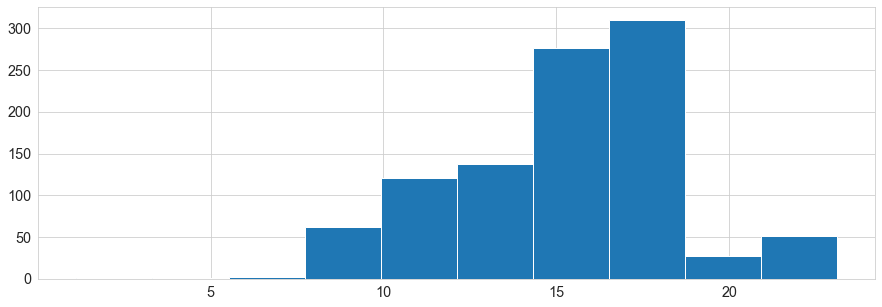

<Figure size 1080x360 with 0 Axes>

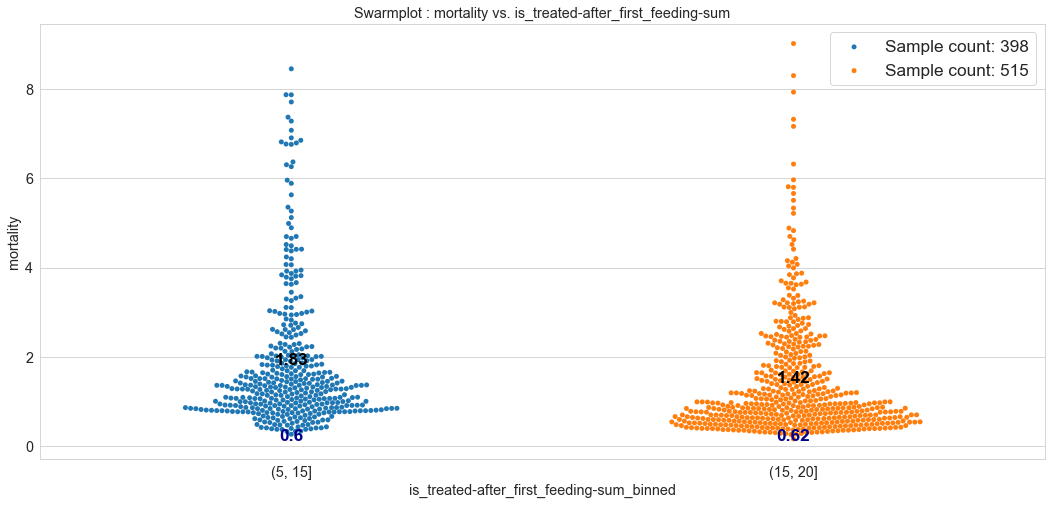

<Figure size 1080x360 with 0 Axes>

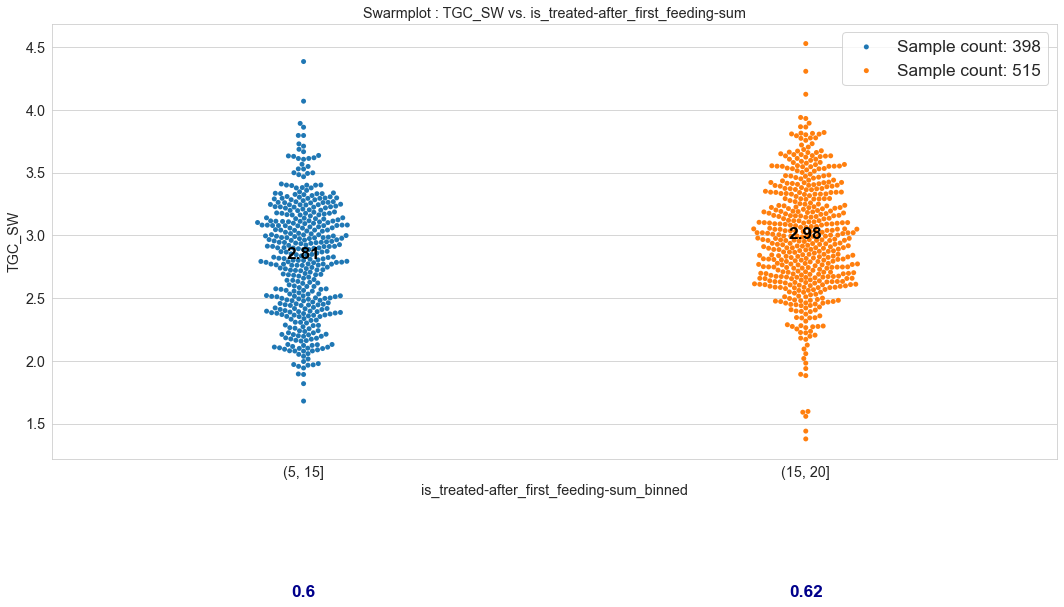

In [25]:
factor = f'{main_factor}-after_first_feeding-sum'
bins = (5, 15, 20)
plt.figure()
factors_treatment[factor].hist()

plot_swarm(factors_treatment,
       factor=factor,
       target='mortality',
       bins=bins,
       y_scale=5,
       title='')

plot_swarm(factors_treatment,
       factor=factor,
       target='TGC_SW',
       bins=bins,
       y_scale=5,
       title='')

### Finding 2: Sum around vaccination

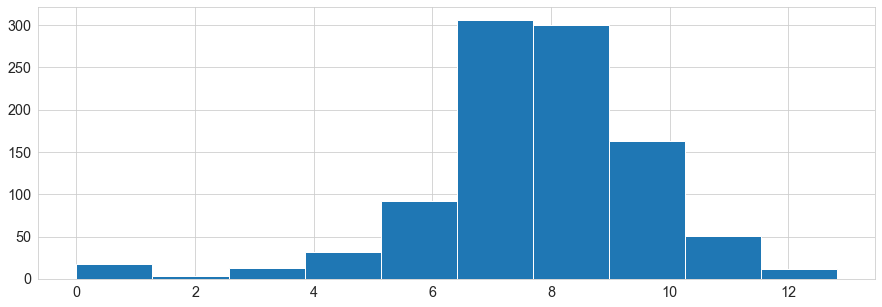

<Figure size 1080x360 with 0 Axes>

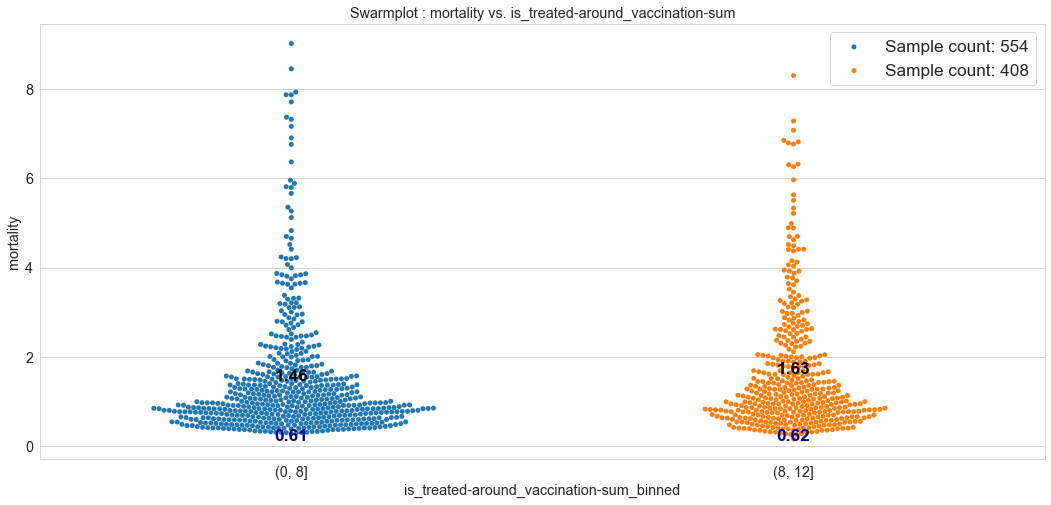

<Figure size 1080x360 with 0 Axes>

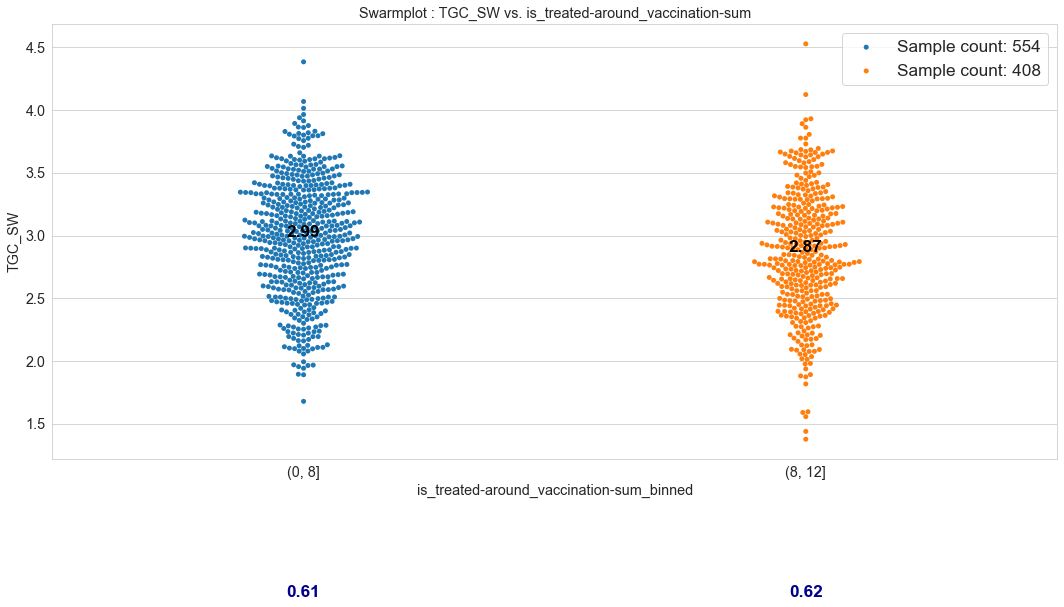

In [29]:
factor = f'{main_factor}-around_vaccination-sum'
bins = (0, 8, 12)
plt.figure()
factors_treatment[factor].hist()

plot_swarm(factors_treatment,
       factor=factor,
       target='mortality',
       bins=bins,
       y_scale=5,
       title='')

plot_swarm(factors_treatment,
       factor=factor,
       target='TGC_SW',
       bins=bins,
       y_scale=5,
       title='')

### Findning 3: Sum transfer_feeding

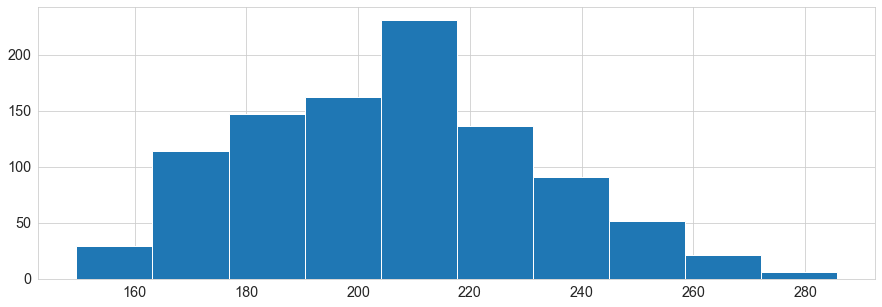

<Figure size 1080x360 with 0 Axes>

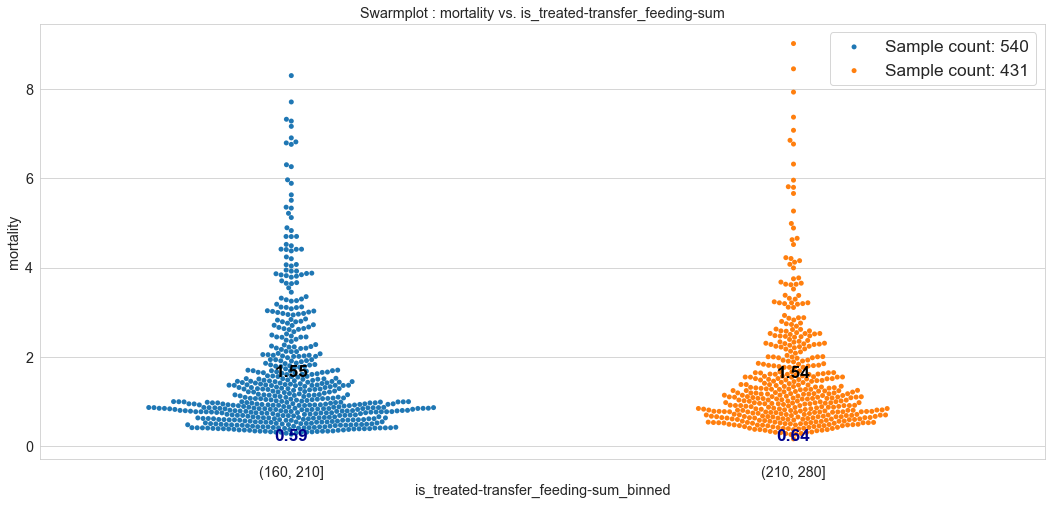

<Figure size 1080x360 with 0 Axes>

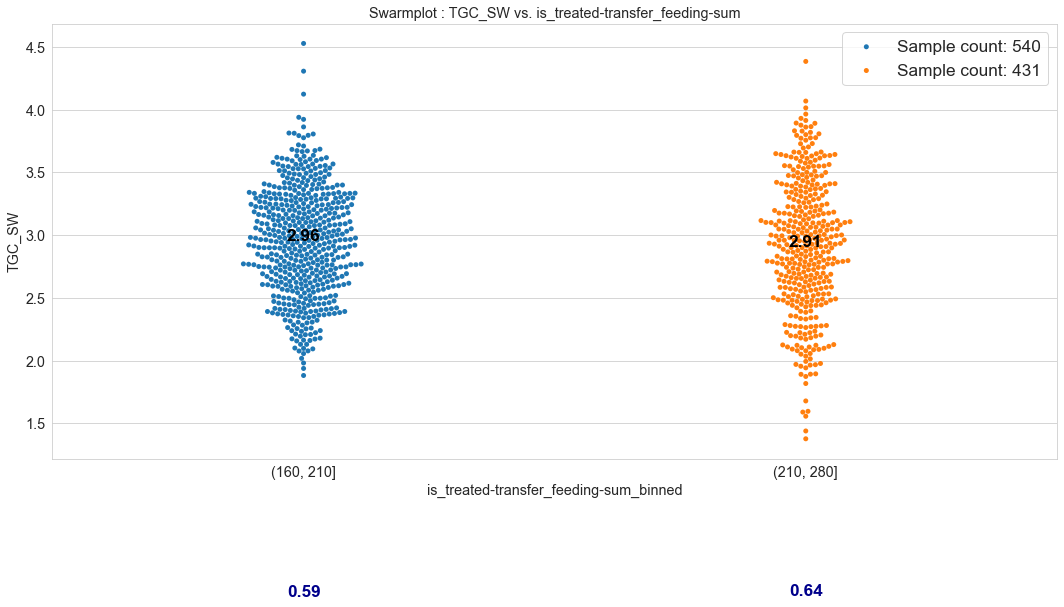

In [31]:
factor = f'{main_factor}-transfer_feeding-sum'
bins = (160, 210, 280)
plt.figure()
factors_treatment[factor].hist()

plot_swarm(factors_treatment,
       factor=factor,
       target='mortality',
       bins=bins,
       y_scale=5,
       title='')

plot_swarm(factors_treatment,
       factor=factor,
       target='TGC_SW',
       bins=bins,
       y_scale=5,
       title='')

### Finding 4: Sum transfer-vaccination

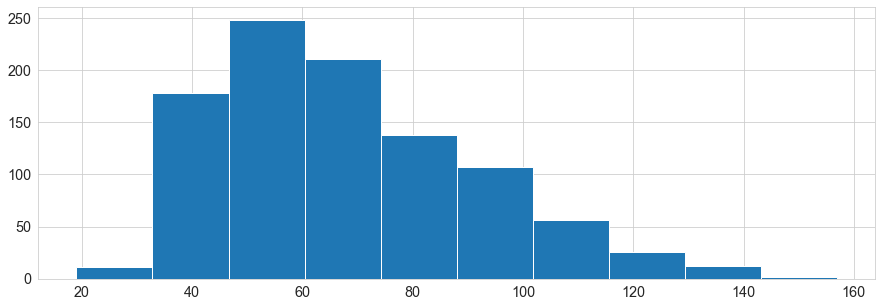

<Figure size 1080x360 with 0 Axes>

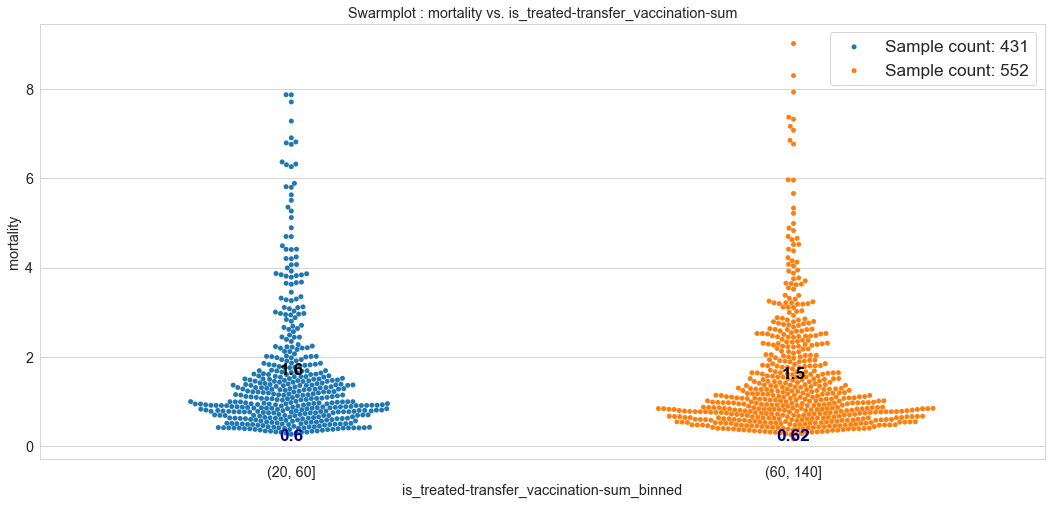

<Figure size 1080x360 with 0 Axes>

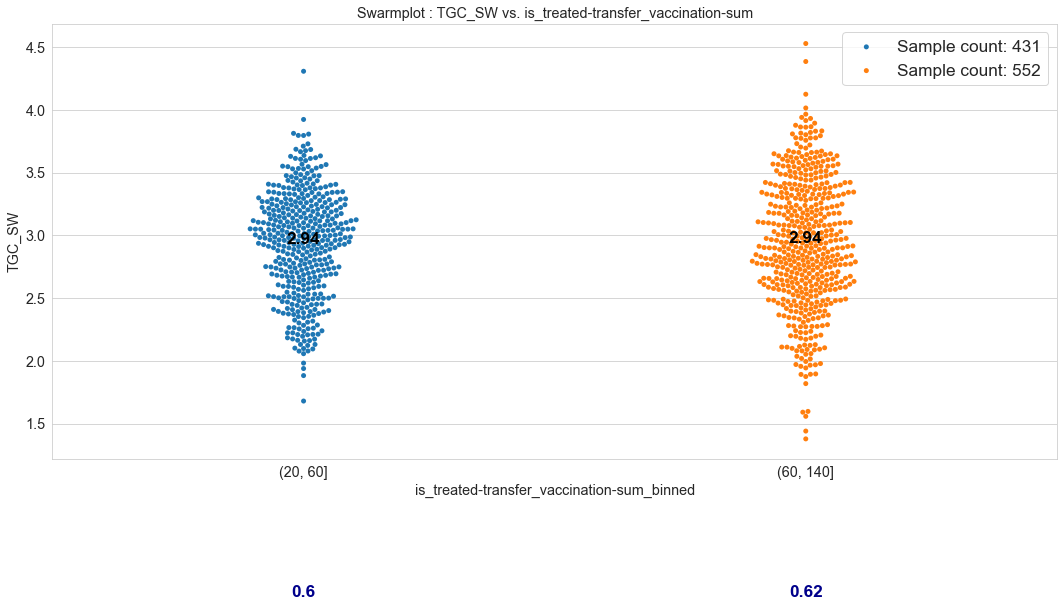

In [34]:
factor = f'{main_factor}-transfer_vaccination-sum'
bins = (20, 60, 140)
plt.figure()
factors_treatment[factor].hist()

plot_swarm(factors_treatment,
       factor=factor,
       target='mortality',
       bins=bins,
       y_scale=5,
       title='')

plot_swarm(factors_treatment,
       factor=factor,
       target='TGC_SW',
       bins=bins,
       y_scale=5,
       title='')

### Findnig 5: Week around vaccintion

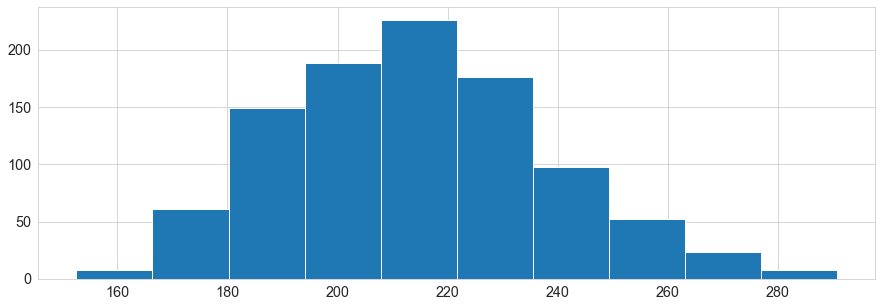

<Figure size 1080x360 with 0 Axes>

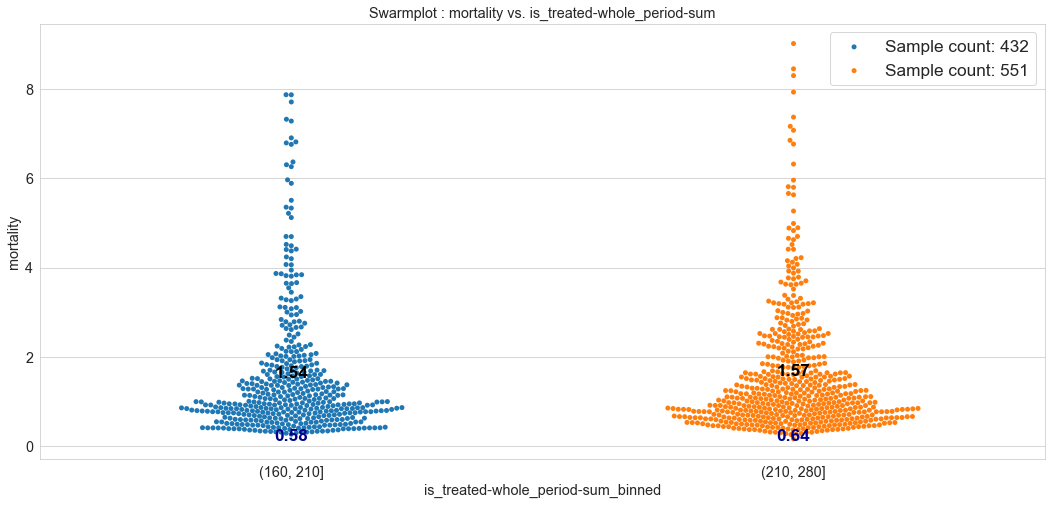

<Figure size 1080x360 with 0 Axes>

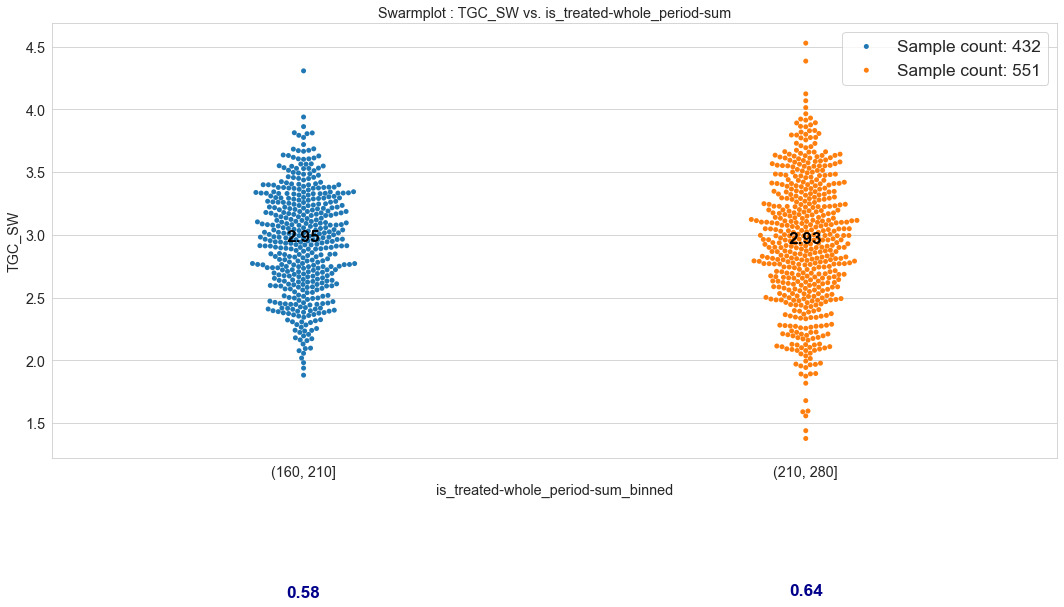

In [36]:
factor = f'{main_factor}-whole_period-sum'
bins = (160, 210, 280)
plt.figure()
factors_treatment[factor].hist()

plot_swarm(factors_treatment,
       factor=factor,
       target='mortality',
       bins=bins,
       y_scale=5,
       title='')

plot_swarm(factors_treatment,
       factor=factor,
       target='TGC_SW',
       bins=bins,
       y_scale=5,
       title='')

### Multiple factors generation

In [12]:
is_cols = [col for col in treatment.columns if 'is_' in col]

In [13]:
is_cols

['is_treated_weighted',
 'is_BRONOPOL_weighted',
 'is_CLORAMINA T_weighted',
 'is_Lufenurón_weighted',
 'is_NACL_weighted',
 'is_SAPROSAFE AW_weighted',
 'is_Bath_weighted',
 'is_Baño sin PMV_weighted',
 'is_Feed_weighted',
 'is_no_reason_weighted',
 'is_caligus _weighted',
 'is_flavobacteria_weighted',
 'is_ipn_weighted',
 'is_micosis_weighted',
 'is_otro_weighted',
 'is_prescription_weighted']

In [ ]:
for main_factor in tqdm(is_cols):
    agg_dfs = []

    for name, func in agg_functions.items():
        if name != 'threshold':
            agg_df = create_ph_aggregated_factors(treatment,
                                                  main_factor,
                                                  agg_function=func,
                                                  function_name=name,
                                                  env_type=main_factor.lower())
            agg_dfs.append(agg_df)
        else:
            for condition_type, condition in threshold_conditions.items():
                agg_df = create_ph_aggregated_factors_threshold(
                    fw_mortality[condition],
                    main_factor,
                    min_threshold,
                    max_threshold,
                    agg_function=func,
                    condition_type=condition_type,
                    env_type=main_factor.lower()
                )
                agg_dfs.append(agg_df)

    # agg_dfs.append(create_degree_days_aggregated_factor(temperature, main_factor, env_type=main_factor.lower()))

    agg_df = pd.concat(agg_dfs)

    agg_df = agg_df.merge(
        mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
        left_on=['final_locus_population_id',],
        right_on=['from_locus_population_id',],
        how='right')

    factors = agg_df.columns.difference(
        ['from_locus_population_id', 'locus_id', 'fish_group_id', 'transfer_year', 'from_count_stocking']
    )

    factors_treatment = create_factors_df(agg_df,
                                            factors,
                                            key_columns, 
                                            weight_column='from_count_stocking',
                                            weighted_func=weighted_avg)
    factors_treatment = factors_treatment.merge(
        pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
        on=key_columns,
        how='inner')

    #factors_treatment = factors_treatment.merge(
    #    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
    #    on=key_columns,
    #    how='inner'
    #)

    factors_treatment.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)

    factors_treatment.to_csv(f'../data/ft/factors_{main_factor.lower()}.csv', index=False)

  0%|          | 0/16 [00:00<?, ?it/s]

Weighting factors



  6%|▋         | 1/16 [01:13<18:29, 73.96s/it]